# Random bathymetry generator
In this script, an attempt is made to generate 'new' bathymetry which retains the spectral characteristics of the original bathymetry.  
The approach is the same as in the 1D case of Ebisuzaki (1997, [doi](https://doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2)) in which a random perturbation is added to the phase of the discrete Fourier transform.  
This code is originally from Tom Bolton, tweaked and adapted to work with a bathymetric dataset.

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
# from ranthymetry import gen_samples
# import xrft
%matplotlib inline

In [30]:
# Load data #
# ETOPO: /work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd
# SRTM topo15: /work/gam/srtm/topo15.grd

filename = '/work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd'
ds = xr.open_dataset(filename)
ds = ds.rename({'x':'lon','y':'lat'})

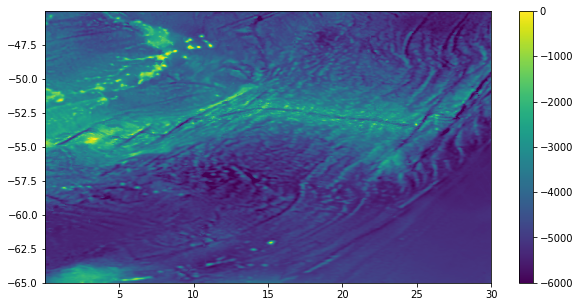

In [54]:
# Select subsection of data
LAT=[-65,-45]
LON=[0,30]
b = ds.z.sel(lat=slice(LAT[0],LAT[1]),lon=slice(LON[0],LON[1]))
b = xr.where(b>0,0,b)

fig, ax = plt.subplots( 1, 1, figsize=(10,5) )
im = ax.pcolormesh(b.lon,b.lat,b.values)
plt.colorbar(im,ax=ax)
im.set_clim([-6000,0])

***
This is a function to apply a random phase shift to the 2D Fourier Transform of bathymetric data  

In [55]:
def gen_samples( f, n_samples, rmethod='new_all', pert_mag = 0, apply_hamming=True, plots=False ) :
    """
    Estimate the 2D power spectrum of the input
    field f, and use random phase sampling to produce
    n_samples of f with the same spectrum of f.
    
    Inputs
    f : 2D array, field to produce samples of
    n_samples : integar, number of samples to generate
    
    Outputs
    samples : 3D array containing the samples of 2D fields
    
    """
    f_orig = f
    Ny, Nx = f.shape
    
    # applying Hamming window
    if apply_hamming :
        
        w_x = np.hamming(Nx)
        w_y = np.hamming(Ny)
        
        win = np.sqrt( np.outer( w_y, w_x ) )
        
        f = f*win
    
    fs = np.zeros( (n_samples,Ny,Nx) )
    dfts = np.zeros( (n_samples,Ny,Nx) , dtype=complex)
    
    # calculate mean and std of f
    f_mean = np.mean(f)
    f_sig = np.std(f)
    
    # remove mean
    f = f-f_mean
    
    # 2D power spectrum calculation
    dft = np.fft.fft2(f)            # compute 2D dft
    dft_orig = dft
    #dft = np.fft.fftshift( psd )    # shift zero frequency
    
    phase = np.angle(dft)
    mod = np.abs(dft)
    
    for i in range(n_samples) :
        
        # There are a number of different ways that we can randomize the phase.
        # These include generating entirely new and random phase (with different ways to create the 2D random array)
        # and applying a small random perturbation to the current phase.
        # It is not presently clear what is the 'correct' way
        # Thus, we have the functionality to choose any method, by setting rmethod
        # The current options are :
            # new_indep_coher  - independently set new phase in x and y, coherent across the other dimension
            # new_indep        - independently set new phase in x and y, but random in both dimensions
            # new_all          - one 2D random field for all wavenumbers in both dimensions
            # perturb          - apply a random perturbation to the current phase
        
        # generate 2D grid of random phases
        # between 0 and 2pi
        
        if rmethod == 'new_indep_coher':
            
            phase_x = np.zeros( Nx )
            phase_y = np.zeros( Ny )
            # In the following, impose zero in first entry of randomised phases
            # Procedure:
                # Randomise entries in phase_* from index 1 to Nx/2
                # (remember in python, index Nx/2 is the entry one greater than the mid-point)
                    # e.g. phase_x = [0 1 2 3 4 0 0 0]
                # Take entries 1 to Nx/2, set them to negative, reverse their order,
                # and put them into phase_* in entries Nx/2 to end
                    # e.g. phase_x = [0 1 2 3 -4 -3 -2 -1]
                # Note that index Nx/2 is set in the first step and then just reversed in sign
                # For an odd number of entries, the entry in index Nx/2 is set twice...
                    # e.g. step 1: phase_x = [0 1 2 3 4 0 0 0 0]
                    # then step 2: phase_x = [0 1 2 3 4 -4 -3 -2 -1]

            if Nx % 2 == 0 :

                phase_x[1:int(Nx/2+1)] = np.random.uniform( size=int(Nx/2) ) * 2 *np.pi
                phase_x[int(Nx/2):] = np.flip(-phase_x[1:int(Nx/2+1)])

            else :

                phase_x[1:int((Nx-1)/2+1)] = np.random.uniform( size=int( (Nx-1)/2) ) * 2 *np.pi
                phase_x[int((Nx-1)/2+1):] = np.flip(-phase_x[1:int((Nx-1)/2+1)])

            if Ny % 2 == 0 :

                phase_y[1:int(Ny/2+1)] = np.random.uniform( size=int(Ny/2) ) * 2 *np.pi
                phase_y[int(Ny/2):] = np.flip(-phase_y[1:int(Ny/2+1)])

            else :

                phase_y[1:int((Ny-1)/2+1)] = np.random.uniform( size=int( (Ny-1)/2) ) * 2 *np.pi
                phase_y[int((Ny-1)/2+1):] = np.flip(-phase_y[1:int((Ny-1)/2+1)])


            phase_x, phase_y = np.meshgrid( phase_x, phase_y )
            phase_new = phase_x + phase_y
            
        elif rmethod == 'new_indep':
            
            phase_x = np.zeros( (Ny,Nx) )
            phase_y = np.zeros( (Ny,Nx) )
            # In the following, impose zero in first entry of randomised phases
            # Procedure:
                # Randomise entries in phase_* from index 1 to Nx/2
                # (remember in python, index Nx/2 is the entry one greater than the mid-point)
                    # e.g. phase_x = [0 1 2 3 4 0 0 0]
                # Take entries 1 to Nx/2, set them to negative, reverse their order,
                # and put them into phase_* in entries Nx/2 to end
                    # e.g. phase_x = [0 1 2 3 -4 -3 -2 -1]
                # Note that index Nx/2 is set in the first step and then just reversed in sign
                # For an odd number of entries, the entry in index Nx/2 is set twice...
                    # e.g. step 1: phase_x = [0 1 2 3 4 0 0 0 0]
                    # then step 2: phase_x = [0 1 2 3 4 -4 -3 -2 -1]

            if Nx % 2 == 0 :

                phase_x[:,1:int(Nx/2+1)] = np.random.uniform( size=(Ny,int(Nx/2)) ) * 2 *np.pi
                phase_x[:,int(Nx/2):] = np.flip(-phase_x[:,1:int(Nx/2+1)])

            else :

                phase_x[:,1:int((Nx-1)/2+1)] = np.random.uniform( size=( Ny, int((Nx-1)/2) ) ) * 2 *np.pi
                phase_x[:,int((Nx-1)/2+1):] = np.flip(-phase_x[:,1:int((Nx-1)/2+1)])

            if Ny % 2 == 0 :

                phase_y[1:int(Ny/2+1),:] = np.random.uniform( size=(int(Ny/2), Nx ) ) * 2 *np.pi
                phase_y[int(Ny/2):,:] = np.flip(-phase_y[1:int(Ny/2+1),:])

            else :

                phase_y[1:int((Ny-1)/2+1),:] = np.random.uniform( size=(int((Ny-1)/2), Nx )) * 2 *np.pi
                phase_y[int((Ny-1)/2+1):,:] = np.flip(-phase_y[1:int((Ny-1)/2+1),:])
                
            phase_new = phase_x + phase_y
        
        elif rmethod == 'new_all':
            
            phase_new = ( 2 * np.random.uniform( size=(Ny,Nx) ) - 1 ) * np.pi
            # (Multiply by 2 minus 1 sets the range between +-1)
            
        elif rmethod == 'perturb':
                 
            phase_new = phase + pert_mag * (2 * np.random.uniform( size=(Ny,Nx) ) -1 ) * 2 * np.pi
            
        # use random phases to construct
        # new 2D sample with same spectrum
        dft_new = mod * np.exp( 1j * phase_new  )
        
        # invert the sample power spectrum
        # and reintroduce mean
        f_new = np.real( np.fft.ifft2( dft_new ) )
        
        # scale to zero mean, unit variance
        f_new = f_new + np.mean( f_new )
        f_new = f_new/np.std( f_new )
                
        # re-scale to variance of original f
        f_new = f_new * f_sig
        f_new = f_new + f_mean
        
        fs[i,:,:] = f_new
        dfts[i,:,:] = dft_new 
        
    if plots:
        # Plot power spectra and bathymetry
        fig, ax = plt.subplots( n_samples+1, 2, figsize=(14,6*n_samples) )
        # Original
        im=ax[0,0].pcolormesh(np.log10(np.abs(dft_orig)**2))
        plt.colorbar(im,ax=ax[0,0])
        im=ax[0,1].pcolormesh(f_orig)
        im.set_clim([-6000,0])
        plt.colorbar(im,ax=ax[0,1])
        # New
        for i in range(n_samples):
            dft_i = np.squeeze(dfts[i,:,:])
            f_i = np.squeeze(fs[i,:,:])
            im=ax[i+1,0].pcolormesh(np.log10(np.abs(dft_i)**2))
            plt.colorbar(im,ax=ax[i+1,0])
            im=ax[i+1,1].pcolormesh(f_i)
            im.set_clim([-6000,0])
            plt.colorbar(im,ax=ax[i+1,1])
 
    return fs, dfts, f_orig, dft_orig, phase_new

## Apply the randomization
Initially without the use of a filter, and then with that filter.  
In the plots, the upper panel is the original data, with randomizations placed below.  
The left panels show the power spectra, the right panels show the bathymetry.

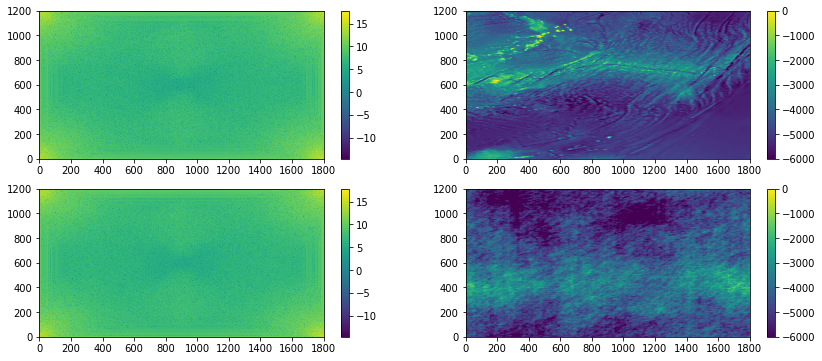

In [56]:
n=1
bs, dfts, b_orig, dft_orig, phase_new = gen_samples(f = b.values,n_samples=n,rmethod='new_all',pert_mag = 0.2, apply_hamming=False, plots=True)

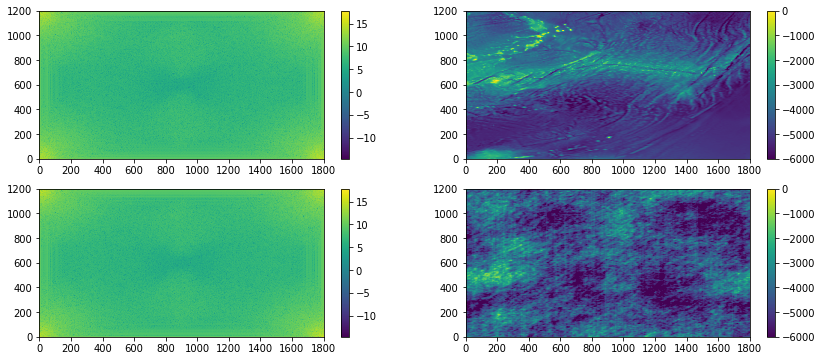

In [57]:
n=1
bs, dfts, b_orig, dft_orig, phase_new = gen_samples(f = b.values,n_samples=n,rmethod='new_indep', apply_hamming=False, plots=True)

In [ ]:
n=1
bs, dfts, b_orig, dft_orig, phase_new = gen_samples(f = b.values,n_samples=n,rmethod='perturb',pert_mag = 0.25, apply_hamming=False, plots=True)

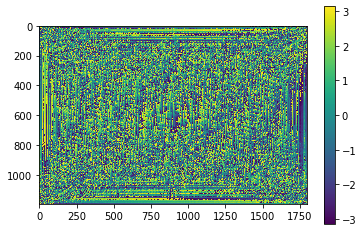

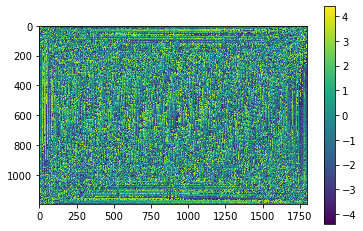

In [51]:
im = plt.imshow(np.angle(dft_orig))
plt.colorbar(im)
plt.show()
im = plt.imshow(phase_new)
plt.colorbar(im)
plt.show()

***
## Further work with xrft, designed for use with xarray

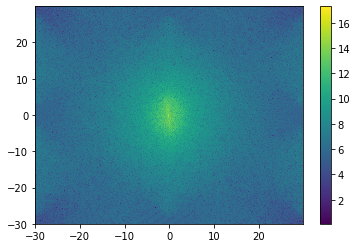

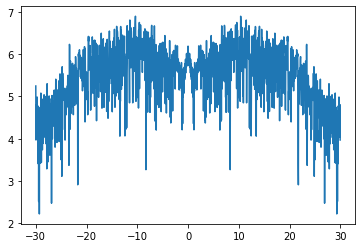

In [32]:
# XRFT
# Perform discrete Fourier transform using xrft
dft = xrft.dft(f,window=True,detrend='constant')
im=plt.pcolormesh(dft.freq_lon,dft.freq_lat,np.log10(np.abs(dft)**2))
plt.colorbar(im)
plt.show()
im=plt.plot(dft.freq_lon,np.log10(np.abs(dft.values[0,:])**2))